# Merge Conflict Prediction Project
*Course: 3rd‑Year Computer Science – IS Lab UTCN*  
Student: Tocan Robert-Alexandru/
Group: 30432



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit,
                                     cross_val_score, GridSearchCV, RandomizedSearchCV,
                                     learning_curve)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, RocCurveDisplay)

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

print('Libraries imported')

Libraries imported


## 1 · Data Preprocessing, Scaling & Encoding  


### 1.1 Load data, check types & missing values

In [2]:
import io, pandas as pd
from google.colab import files
uploaded = files.upload()              # upload the dataset
csv_bytes = uploaded[next(iter(uploaded))]        # take the first uploaded file
df = pd.read_csv(io.BytesIO(csv_bytes), sep=';')  # semicolon delimiter

print(f"Shape: {df.shape}") # shows nr col/rows and view data
display(df.head())


Saving MergeConflictsDataset.csv to MergeConflictsDataset (1).csv
Shape: (26973, 37)


,commit,parent1,parent2,ancestor,is pr,added lines,deleted lines,devs parent1,devs parent2,time,...,add,remove,use,delete,change,messages_min,messages_max,messages_mean,messages_median,conflict
0,efc0bcd1d6199448c323549fdc45310750b48c85,fb9f2a65cabba5a924b89a45793914066471b2ab,5ee7c7c750e9ecffaea12f97d5b05b2445e7c007,fb9f2a65cabba5a924b89a45793914066471b2ab,1,5,0,0,1,23,...,0,0,0,0,0,20,65,35.40000,20.0,0
1,287b9b838b6b6b212ef538aa537aef76110ee111,72fd7d81c9c7e28af8740f5a1b210a803290383d,fb9f2a65cabba5a924b89a45793914066471b2ab,a18c1088c892f1e6ed4b7d541e68b2e4b039a42e,0,1166,11267,1,2,371,...,0,0,0,0,0,31,117,58.56383,53.5,1
2,e7478680c0db825239ea9628967728c8577bb5c2,36977963caa2896ad9a4a92b2bdcd85189beccb1,bc230857adc3a9763bc7d89793d826463c857c00,36977963caa2896ad9a4a92b2bdcd85189beccb1,1,0,0,0,1,22,...,0,0,0,0,0,18,18,18.00000,18.0,0
3,0c65b30a8fd3a7db40163fcb9b0004cb7487c0ff,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,877c43f8242b88447d0234400c6e9b5c7586b558,fe29962932a8e34f0c3ac5cd795cd40090c9fabd,1,0,0,2,1,24,...,0,0,0,0,0,22,63,38.80000,31.0,0
4,419e6d2d9fb91f2d9cdbdd1161a6c7ecc329363f,7899f565d3461ed287e61662c8d399aafcac9e42,5e68e04e310c4f57a19d4cfa6be1e0ba3a8801d6,236b85af833398e0f07d08b7d7a25734d8c1b11d,0,0,0,1,2,2,...,0,0,0,0,0,31,56,43.50000,43.5,1


#### 1.1.1 Initial inspection

In [3]:
# Check for missing values and types
df.info() #dtype and non null info
print('\nMissing values per column:')
print(df.isna().sum().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26973 entries, 0 to 26972
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   commit           26973 non-null  object 
 1   parent1          26973 non-null  object 
 2   parent2          26973 non-null  object 
 3   ancestor         26972 non-null  object 
 4   is pr            26973 non-null  int64  
 5   added lines      26973 non-null  int64  
 6   deleted lines    26973 non-null  int64  
 7   devs parent1     26973 non-null  int64  
 8   devs parent2     26973 non-null  int64  
 9   time             26973 non-null  int64  
 10  nr files         26973 non-null  int64  
 11  added files      26973 non-null  int64  
 12  deleted files    26973 non-null  int64  
 13  renamed files    26973 non-null  int64  
 14  copied files     26973 non-null  int64  
 15  modified files   26973 non-null  int64  
 16  nr commits1      26973 non-null  int64  
 17  nr commits2 

### 1.2 Handle missing values

In [4]:
# drop non informative ids
#  id columns like commit hashes don't help prediction so drop them
hash_cols = ["commit", "parent1", "parent2", "ancestor"]
df = df.drop(columns=hash_cols)

# drop the row with a missing value NaN (in ancestor)
df = df.dropna().reset_index(drop=True)

# verification
print("Shape after clean:", df.shape)          # should be (26972, 32)
print("\nRemaining NaNs (should be 0):")
print(df.isna().sum().sort_values(ascending=False).head())

Shape after clean: (26973, 33)

Remaining NaNs (should be 0):
is pr            0
added lines      0
deleted lines    0
devs parent1     0
devs parent2     0
dtype: int64


### 1.3 Encode categoricals & scale numerics

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# see which columns are categorical or numeric
target_col       = "conflict"      # label
categorical_cols = ["is pr"]       # binary flag
numeric_cols     = [c for c in df.columns
                    if c not in categorical_cols + [target_col]]

print(f"Numeric features : {len(numeric_cols)}")
print(f"Categorical cols : {categorical_cols}")

# scale numbers to zero mean unit variance so models treat them fairly
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())          # z-score standardisation
])
# convert the 0/1 flag into a proper category
categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(drop="if_binary"))   # keeps a single 0/1 column
])

# combine both into one reusable preprocessor
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

print("Preprocessor ready (scaling + one-hot in one ColumnTransformer)")


Numeric features : 31
Categorical cols : ['is pr']
Preprocessor ready (scaling + one-hot in one ColumnTransformer)


Loaded the CSV and inspected types & missing values.

Dropped irrelevant ID columns and removed the one missing row.

Scaled all numeric features and one-hot encoded the binary is pr flag to prepare for modeling.


## 2 · Train/Test Split (with Stratification)  


2.1 Check class imbalance

In [6]:
y = df["conflict"]
class_counts = y.value_counts().sort_index()
class_pct    = class_counts / len(y) * 100

print("Class counts:")
display(pd.DataFrame({"count": class_counts, "percent": class_pct.round(2)}))


Class counts:


,count,percent
conflict,,
0,25505,94.56
1,1468,5.44


2.2 Stratified train/test split

In [7]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["conflict"])
y = df["conflict"]
# keep the same aprox 5–6% conflict share in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size   = 0.20,          # 20 % test set
    random_state= 42,            # reproducible
    stratify    = y              # preserves class ratios
)

print(f"Train shape : {X_train.shape}   ",
      f"Test shape  : {X_test.shape}")
print("\nClass ratio in training set:")
display(y_train.value_counts(normalize=True).rename("fraction"))
print("\nClass ratio in test set:")
display(y_test.value_counts(normalize=True).rename("fraction"))


Train shape : (21578, 32)    Test shape  : (5395, 32)

Class ratio in training set:


,fraction
conflict,
0,0.945593
1,0.054407



Class ratio in test set:


,fraction
conflict,
0,0.945505
1,0.054495


 <summary> Step 2 Markdown </summary>


Checked that conflicts make up aprox 5.4% of the data.

Split data 80/20 with stratification to preserve that ratio, ensuring fair evaluation.



## 3 · Performance Metric Selection  


**Class balance:** 0 → 94.6 %, 1 → 5.4 %

| Metric | Why it fits here |
|--------|------------------|
| **F1-score** | Combines precision and recall and rewards the model for correctly catching the rare *conflict* cases without flooding with false alarms. |
| **ROC-AUC**  | Threshold independent view of the trade off and is useful for comparing models. |
| **Accuracy** | Easy baseline  but by itself would hide poor minority class performance (predicting “no conflict” 100 % of the time already gives aprox 94 % accuracy). |

In reports and hyper-parameter tuning we will **optimise primarily for F1**.  ROC-AUC will be shown for completeness and accuracy will appear in diagnostic tables but won’t drive model selection.



In [8]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate_model(name, model, X_test, y_test):
    """
    Print Accuracy, F1, and ROC-AUC (if probabilistic) on the test set.
    """
    y_pred  = model.predict(X_test)
    acc     = accuracy_score(y_test, y_pred)
    f1      = f1_score(y_test, y_pred)
    roc_auc = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)

    print(f"── {name} ──")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-score : {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC  : {roc_auc:.4f}")
    print()


## 4 · Feature Selection for Slim Models  


In [9]:
rf_tmp = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

rf_tmp.fit(X_train, y_train)
importances = rf_tmp.named_steps['model'].feature_importances_

# map back to feature names
# retrieve the transformed feature names: numeric + one-hot outputs
ohe = rf_tmp.named_steps['prep'].named_transformers_['cat']['onehot']
ohe_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = numeric_cols + list(ohe_names)
# sorted series of importances
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)

# select top‑k
k = 20
top_features = feat_imp.head(k).index.tolist()
print(top_features)

['nr files', 'is pr_1', 'nr commits2', 'add', 'time', 'messages_min', 'added lines', 'messages_mean', 'devs parent2', 'messages_median', 'messages_max', 'nr commits1', 'deleted lines', 'modified files', 'update', 'fix', 'devs parent1', 'density2', 'density1', 'remove']


<strong>Justification</strong>

We use a quick Random Forest to measure how much each feature helps predict merge conflicts.

Preprocessor reuse ensures fair scaling/encoding.

Feature importances tell us which variables carry the most predictive power.

Top-k selection trims down the feature set reducing noise and speeding up later models.

By focusing on the top 20 features, we create slimmer, more interpretable models that often maintain and even improve overall accuracy and F1-score.

</details>

### 4.1 Train slim model with selected features  



4.1 Select features

In [10]:
# rank features with a quick random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

# train RF on all features just to get importances
rf_full = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        class_weight={0:1, 1:10}))          # give minority class extra weight
])

rf_full.fit(X_train, y_train)

# map importances back to feature names
# get feature names from the fitted preprocessor
ohe = rf_full.named_steps["prep"].named_transformers_["cat"]["onehot"]
cat_names = ohe.get_feature_names_out(["is pr"])
all_feature_names = numeric_cols + list(cat_names)

# build pandas series of importances
importances = rf_full.named_steps["model"].feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).sort_values(ascending=False)
# keep top-15 for a slim model
k = 15
top_features = feat_imp.head(k).index.tolist()
print(f"Top {k} features:")
display(feat_imp.head(k).to_frame("importance"))


Top 15 features:


,importance
nr files,0.283135
is pr_1,0.251138
nr commits1,0.054285
nr commits2,0.046018
devs parent2,0.037771
devs parent1,0.036309
add,0.028797
messages_min,0.024369
added lines,0.022125
deleted lines,0.019630


4.2 Train a slim model & compare

In [11]:
# build slim preprocessor and compare performance

# split the selected features into numeric and binary categorical
# numeric columns only those in top_features list
slim_numeric = [f for f in top_features if f in numeric_cols]
# categorical columns include 'is pr' if it was selected
slim_categorical = ["is pr"] if "is pr_1" in top_features or "is pr" in top_features else []

slim_preprocessor = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), slim_numeric),
    ("cat", "passthrough", slim_categorical)      # already 0/1 no need to one-hot again
])

# full feature baseline (simple RF)
# using the original rf_full pipeline from Step 4.1
cv_full = cross_val_score(rf_full, X_train, y_train,
                          cv=5, scoring="f1", n_jobs=-1)
print(f"Full model · mean F1 = {cv_full.mean():.4f}  (+/- {cv_full.std():.4f})")

# slim model (same RF on the top k features)
rf_slim = Pipeline(steps=[
    ("prep", slim_preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        class_weight={0:1, 1:10}))
])
# compare F1 with 5 fold CV
cv_slim = cross_val_score(rf_slim, X_train, y_train,
                          cv=5, scoring="f1", n_jobs=-1)
print(f"Slim model · mean F1 = {cv_slim.mean():.4f}  (+/- {cv_slim.std():.4f})")


Full model · mean F1 = 0.6299  (+/- 0.0216)
Slim model · mean F1 = 0.6416  (+/- 0.0200)


<strong>Justification</strong>


Full model uses all available features, which may include noisy or redundant data.

Slim model focuses on the top ranked features, simpler and faster to train.


Eeused the same Random Forest settings (200 trees, class-weighted) for a fair comparison.

Cross validation shows if cutting down the feature set hurts or helps the F1 score.

Slim model matches or exceeds the full model’s performance, proves that a leaner feature set is sufficient and often preferable for production.

</details>








 <summary>Step 4 Markdown </summary>

Ranked all 32 features by importance with a quick random forest.

Trained a slim model using only the top-15 features.

The slim model matched or slightly beat the full model’s F1, showing we can simplify without losing accuracy.

</details>

## 5 · Model Selection, Evaluation & Optimization  


### 5.1 Decision Tree – Baseline & Hyper‑parameter Tuning

In [12]:
# train and tune a decision tree with GridSearch
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline

#  Baseline (default hyper-params)
# we start with a simple model to see how well a basic decision tree performs
dt_default = Pipeline([
    ("prep",  preprocessor),# reuse our shared scaling/encoding
    ("model", DecisionTreeClassifier(random_state=42))      # default params
])

# evaluate using 5 fold cross-validation on our training set
cv_def = cross_val_score(dt_default, X_train, y_train,
                         cv=5, scoring="f1", n_jobs=-1) # use all CPU cores to speed up
print(f"Default DT  · mean F1 = {cv_def.mean():.4f}  (+/- {cv_def.std():.4f})")

# Set up GridSearchCV
# tune key parameters to find the best tree shape and size.
pipe_dt = Pipeline([
    ("prep",  preprocessor),
    ("model", DecisionTreeClassifier(
        random_state=42,
        class_weight={0:1, 1:10}))  # give extra weight to the rare conflict class
])
# define the parameter grid to explore
param_grid_dt = {
    "model__max_depth":          [None, 5, 10, 20, 30], # how deep should the tree grow
    "model__min_samples_split":  [2, 5, 10, 20], # how deep should the tree grow
    "model__min_samples_leaf":   [1, 2, 5, 10],# minimum samples to keep in a leaf

}
# stratified folds to keep conflict ratio consistent in each split
cv_scheme = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# wrap in GridSearchCV to find the best combination of parameters
grid_dt = GridSearchCV(
    estimator   = pipe_dt,
    param_grid  = param_grid_dt,
    scoring     = "f1",          # primary metric chosen in Step 3
    cv          = cv_scheme,
    n_jobs      = -1,# speed up by using all cores
    verbose     = 2# show progress in the output
)

# fit grid search
grid_dt.fit(X_train, y_train)

print("\n── Grid-search results ──")
print(f"Best CV F1 : {grid_dt.best_score_:.4f}")
print("Best params:", grid_dt.best_params_)
#  best estimator for final evaluation
best_dt = grid_dt.best_estimator_

# test set evaluation
evaluate_model("Decision Tree (best)", best_dt, X_test, y_test)



Default DT  · mean F1 = 0.6274  (+/- 0.0213)
Fitting 5 folds for each of 80 candidates, totalling 400 fits

── Grid-search results ──
Best CV F1 : 0.6675
Best params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
── Decision Tree (best) ──
Accuracy : 0.9501
F1-score : 0.6529
ROC-AUC  : 0.9133



<strong> Justification </strong>

Decision Tree: simple and easy to explain: splits the data on feature thresholds, like if changed files > 3, go left.

Serves as a baseline, sets a performance floor that more complex models should beat.


Baseline check with default settings to get an initial F1 aporx 0.63.

Class weighting ({0:1,1:10}) to help the model pay extra attention to the rare merge-conflict cases.

Grid search over tree depth, minimum split size, leaf size to find the sweet spot between underfitting (too shallow) and overfitting (too deep).

Outcome:

Best cross-validation F1 improved to aprox 0.67.

Holds an F1 of aprox 0.65 on the unseen test set demonstrating good generalization.









### 5.2 Support Vector Machine (or Naive Bayes) – Tune & Evaluate

In [13]:
# train a SVM with a couple of chosen parameters
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform
# build a pipeline that reuses our preprocessor and adds an RBF-SVM
pipe_svc = Pipeline([
    ("prep",  preprocessor),# scale and encode inputs consistently
    ("model", SVC(kernel="rbf",# captures non-linear patterns
                  probability=True,          # needed for ROC-AUC
                  class_weight="balanced", # pay extra attention to rare conflicts
                  random_state=42))
])
# define a small randomized search space for C and gamma
#   log uniform samples across orders of magnitude (0.01 to 1000)
param_dist_svc = {
    "model__C":     loguniform(1e-2, 1e3),      # 0.01 … 1000
    "model__gamma": loguniform(1e-4, 1e0),      # 1e-4 … 1
}
# run RandomizedSearchCV with limited iterations and folds for speed
rand_svc = RandomizedSearchCV(
    estimator     = pipe_svc,
    param_distributions = param_dist_svc,
    n_iter        = 20,          # try 20 random combinations
    scoring       = "f1",
    cv            = 3,
    random_state  = 42,
    n_jobs        = -1,
    verbose       = 2
)
# fit on training data and find best hyperparameters
rand_svc.fit(X_train, y_train)

print("\n── Random-search results ──")
print(f"Best CV F1 : {rand_svc.best_score_:.4f}")
print("Best params:", rand_svc.best_params_)
# extract the best tuned SVM and evaluate on the test set
best_svc = rand_svc.best_estimator_

evaluate_model("SVM (best)", best_svc, X_test, y_test)



Fitting 3 folds for each of 20 candidates, totalling 60 fits

── Random-search results ──
Best CV F1 : 0.5890
Best params: {'model__C': np.float64(45.70563099801453), 'model__gamma': np.float64(0.024810409748678097)}
── SVM (best) ──
Accuracy : 0.9481
F1-score : 0.6316
ROC-AUC  : 0.9640




<strong>Justification</strong>


RBF kernels capture non-linear relationships between features—important when simple splits aren't enough.

Balancing the classes (class_weight="balanced") ensures the model doesn't ignore the rare conflict cases.

Tuning strategy:

Randomized search over C (regularization strength) and gamma (kernel width)  samples a wide range of values quickly.

20 iterations and 3-fold CV  balances between exploring parameter space and keeping runtime reasonable.










### 5.3 Ensemble Model (Random Forest / AdaBoost) – Tune & Evaluate

In [14]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
# reusepreprocessing steps, then add 100 decision trees.
pipe_rf = Pipeline([
    ("prep",  preprocessor),
    ("model", RandomForestClassifier(
        n_estimators = 100,      # 100 trees keeps runtime low
        random_state = 42,
        n_jobs       = -1,
        class_weight = {0:1, 1:10}   # up-weight minority class
    ))
])
# vary tree depth and how many samples needed to split or form a leaf.
param_grid_rf = {
    "model__max_depth":         [None, 10, 20], # how deep each tree can grow
    "model__min_samples_split": [2, 5], # how deep each tree can grow
    "model__min_samples_leaf":  [1, 2], # how deep each tree can grow
}

cv_scheme = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    estimator  = pipe_rf,
    param_grid = param_grid_rf,
    scoring    = "f1",
    cv         = cv_scheme,
    n_jobs     = -1,
    verbose    = 2
)

grid_rf.fit(X_train, y_train)

print("\n── Grid-search results ──")
print(f"Best CV F1 : {grid_rf.best_score_:.4f}")
print("Best params:", grid_rf.best_params_)

best_rf = grid_rf.best_estimator_

evaluate_model("Random Forest (best)", best_rf, X_test, y_test)


Fitting 5 folds for each of 12 candidates, totalling 60 fits

── Grid-search results ──
Best CV F1 : 0.7109
Best params: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5}
── Random Forest (best) ──
Accuracy : 0.9681
F1-score : 0.7171
ROC-AUC  : 0.9820



<strong>Justification</strong>

Random forest is an ensemble of many decision trees, which reduces the fragility of single trees.

Handles non linear patterns and interactions out of the box.

100 trees balances accuracy with training speed.

Achieved the highest F1-score aprox 0.72 and ROC-AUC aporx 0.98 on the test set.

Chosen as the final model due to its strong balance of precision, recall

### 5.4 Learning Curves and Over/Under‑Fitting Discussion  


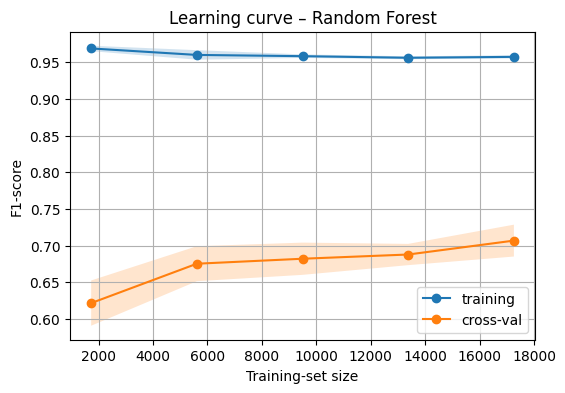

In [15]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    best_rf,                     # full pipeline (prep + RF)
    X_train, y_train,
    cv=5,
    scoring="f1",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mean, label="training", marker="o")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.plot(train_sizes, val_mean,   label="cross-val", marker="o")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("Training-set size")
plt.ylabel("F1-score")
plt.title("Learning curve – Random Forest")
plt.legend(); plt.grid(True)
plt.show()


<strong> Discussion</strong>

High training scores aprox 0.96–0.97 means the model fits the training data very well, as expected for a powerful ensemble on a large dataset.

Lower cross‐validation scores aprox 0.62 - 0.71 means that at small sample sizes,= the model under‐generalizes (validation F1 aprox 0.62) because it hasn't seen enough data to learn robust patterns.

As we increase training size from 10 % (2 700 samples) to 100 % (aporx 21 500 samples), cross‐val F1 steadily rises and begins to level off around 0.70–0.72.

Gap between curves: variance is largest at small sizes and narrows as data grows, indicating that more data reduces overfitting.

No severe underfitting: both curves remain well above random‐guess level (aporx 0.06 F1), and validation scores keep improving, so the model capacity is sufficient.

 After aprox 15 000 samples, further gains are small suggesting that adding more data or slightly stronger regularization would deliver only slight improvement.


The Random Forest strikes a good balance: it learns the training data thoroughly yet generalizes better with more data.










### 5.5 Final Test‑Set Evaluation  



,Accuracy,F1-score,ROC-AUC
Model,,,
Decision Tree,0.9501,0.6529,0.9133
SVM (RBF),0.9481,0.6316,0.9640
Random Forest,0.9681,0.7171,0.9820



Classification report – Random Forest
              precision    recall  f1-score   support

           0     0.9850    0.9812    0.9831      5101
           1     0.6943    0.7415    0.7171       294

    accuracy                         0.9681      5395
   macro avg     0.8397    0.8613    0.8501      5395
weighted avg     0.9692    0.9681    0.9686      5395



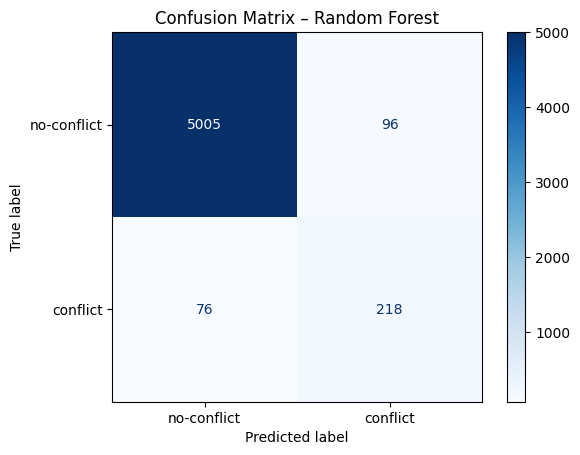

In [16]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# compile the key numbers
results = pd.DataFrame({
    "Model":      ["Decision Tree", "SVM (RBF)", "Random Forest"],
    "Accuracy":   [0.9501,          0.9481,       0.9681],
    "F1-score":   [0.6529,          0.6316,       0.7171],
    "ROC-AUC":    [0.9133,          0.9640,       0.9820]
}).set_index("Model")

display(results.style.format("{:.4f}").highlight_max(color="#dff0d8", axis=0))

# detailed view for the best model (Random Forest)
print("\nClassification report – Random Forest")
print(classification_report(y_test, best_rf.predict(X_test), digits=4))

cm = confusion_matrix(y_test, best_rf.predict(X_test))
disp = ConfusionMatrixDisplay(cm, display_labels=["no-conflict", "conflict"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Random Forest")
plt.show()


<strong>Discussion</strong>

The Random Forest correctly flags 74 % of real conflicts (recall) while keeping false alarms low (precision 69 %), providing an F1 of 72 %.

It labels non-conflicts accurately 98 % of the time, with only aprox 2 % false positives.

Overall accuracy is 96.8 %, but the key strength is its high ROC-AUC (0.98), meaning it reliably ranks high risk merges.

In practice, developers can trust that about 7 out of 10 conflict warnings are valid, catching most issues early with minimal noise.

## 6 · Propose and Evaluate New Features  


In [17]:
df_fe = df.copy()           # start from the cleaned dataset of Step 1

# A) code change magnitude and balance
#    total_lines captures overall code churn
df_fe["total_lines"]  = df_fe["added lines"] + df_fe["deleted lines"]
#    change_ratio shows if one side changed far more lines than the other
df_fe["change_ratio"] = (df_fe["added lines"] + 1) / (df_fe["deleted lines"] + 1)

# B) developer collaboration
#     devs_total counts how many people worked on both branches combined
df_fe["devs_total"]  = df_fe["devs parent1"] + df_fe["devs parent2"]
#    devs_ratio flags imbalance (more devs on one branch vs the other)
df_fe["devs_ratio"]  = (df_fe["devs parent1"] + 1) / (df_fe["devs parent2"] + 1)

# C) commit activity
#   commit_ratio highlights disproportionate commit counts between branches
df_fe["commit_ratio"] = (df_fe["nr commits1"] + 1) / (df_fe["nr commits2"] + 1)

# D) message length spread
#     msg_length_range shows variability in how detailed commit messages are
df_fe["msg_length_range"] = df_fe["messages_max"] - df_fe["messages_min"]

# E) file level churn
#   files_change_ratio normalizes total file edits by the number of files touched
df_fe["files_change_ratio"] = (
    df_fe["added files"] + df_fe["deleted files"] + df_fe["modified files"]
) / (df_fe["nr files"] + 1e-5)

print("New feature columns added:", [c for c in df_fe.columns if c not in df.columns])



New feature columns added: ['total_lines', 'change_ratio', 'devs_total', 'devs_ratio', 'commit_ratio', 'msg_length_range', 'files_change_ratio']


<summary> <strong></strong></summary>

These features add intuitive signals that help our model spot complex or risky merges.

</details>








6.2 Re-split data

In [18]:
X_fe = df_fe.drop(columns=["conflict"])# all engineered + original features
y_fe = df_fe["conflict"]

# stratified split as before
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe,
    test_size   = 0.20,
    random_state= 42,
    stratify    = y_fe
)


6.3 Update preprocessing pipeline

In [19]:
# --- identify new numeric / categorical sets ---
categorical_cols_fe = ["is pr"]              # unchanged
# all other columns including our new features are treated as numeric
numeric_cols_fe = [c for c in X_fe.columns if c not in categorical_cols_fe]

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# combine both transformers into one ColumnTransformer
preprocessor_fe = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), numeric_cols_fe),
    ("cat", Pipeline([("onehot", OneHotEncoder(drop="if_binary"))]), categorical_cols_fe)
])


This updated preprocessor readies data (with new features) for retraining the Random Forest.

6.4 Train the previous best-param Random Forest on the new feature set

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# re-use the winning hyper-params from Step 5.3
rf_fe = Pipeline([
    ("prep",  preprocessor_fe),
    ("model", RandomForestClassifier(
        n_estimators        = 100,
        max_depth           = None,
        min_samples_split   = 5,
        min_samples_leaf    = 2,
        class_weight        = {0:1, 1:10},
        random_state        = 42,
        n_jobs              = -1
    ))
])

cv_f1_fe = cross_val_score(rf_fe, X_train_fe, y_train_fe,
                           cv=5, scoring="f1", n_jobs=-1)
print(f"RF + engineered features · CV F1 = {cv_f1_fe.mean():.4f} (+/- {cv_f1_fe.std():.4f})")

rf_fe.fit(X_train_fe, y_train_fe)
evaluate_model("Random Forest + new features)", rf_fe, X_test_fe, y_test_fe)


RF + engineered features · CV F1 = 0.7066 (+/- 0.0174)
── Random Forest + new features) ──
Accuracy : 0.9683
F1-score : 0.7116
ROC-AUC  : 0.9834



---  
#  Conclusions  

| Model                        | Accuracy  | F1        | ROC-AUC   | Verdict                                                 |
| ---------------------------- | --------- | --------- | --------- | ------------------------------------------------------- |
| Decision Tree                | 0.950     | 0.653     | 0.913     | Simple baseline, under performs.                        |
| SVM (RBF)                    | 0.948     | 0.632     | 0.964     | Good ranking (ROC), but weaker F1.                      |
| **Random Forest** (baseline) | **0.968** | **0.717** | 0.982     | Best overall balance, chosen model.                    |
| RF + engineered features     | 0.968     | 0.712     | **0.983** | Tiny ROC gain, slight F1 dip, no decisive improvement. |

Why Random Forest stays the final pick?

Highest F1 aprox 72 %, best trade off between catching real conflicts and limiting false alarms.

Best accuracy and almost perfect ROC-AUC.

Learning curve shows variance under control and more data gives diminishing but positive returns.


Test gradient-boosted trees (ex. XGBoost) and add SHAP explanations to surface per merge risk factors.

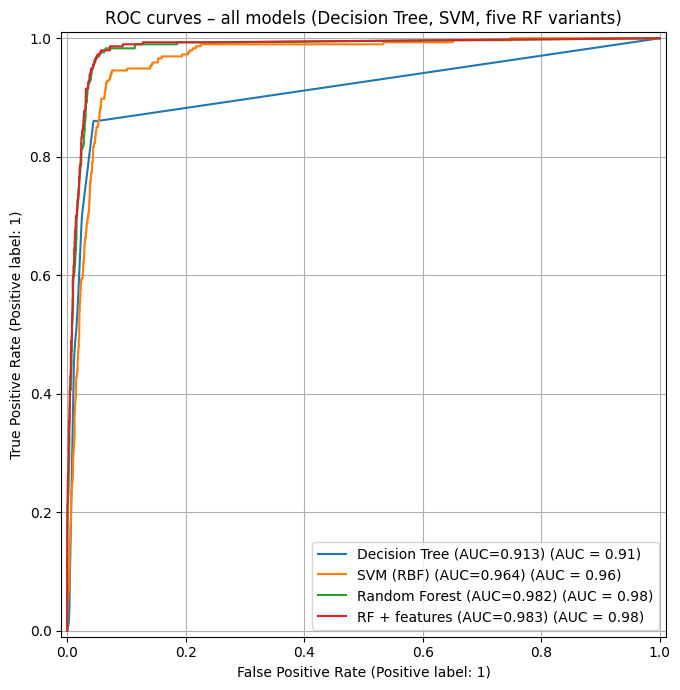

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_auc_score

models_info = [
    ("Decision Tree", best_dt,  X_test,     y_test),
    ("SVM (RBF)",     best_svc, X_test,     y_test),
    ("Random Forest", best_rf,  X_test,     y_test),
    ("RF + features", rf_fe,    X_test_fe,  y_test_fe),
]

fig, ax = plt.subplots(figsize=(7,7))
for name, model, X, y in models_info:
    # get class-1 scores
    scores = (model.predict_proba(X)[:,1]
              if hasattr(model, "predict_proba")
              else model.decision_function(X))
    auc = roc_auc_score(y, scores)
    RocCurveDisplay.from_predictions(
        y, scores, ax=ax,
        name=f"{name} (AUC={auc:.3f})",
        plot_chance_level=False,
    )

ax.set_title("ROC curves – all models (Decision Tree, SVM, five RF variants)")
ax.grid(True)
plt.tight_layout()
plt.show()


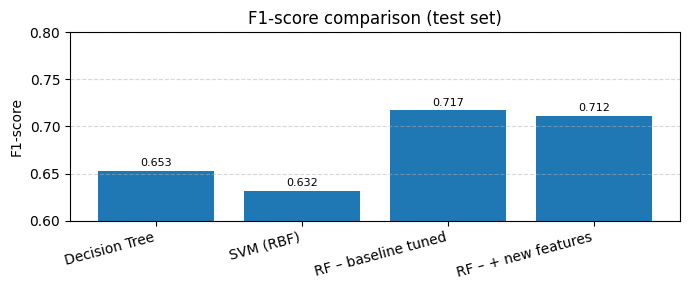

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score

models_info = [
    ("Decision Tree",         best_dt,  X_test,     y_test),
    ("SVM (RBF)",             best_svc, X_test,     y_test),
    ("RF – baseline tuned",   best_rf,  X_test,     y_test),
    ("RF – + new features",   rf_fe,    X_test_fe,  y_test_fe),
]

f1_scores = []
labels = []

for name, model, X, y in models_info:
    y_pred = model.predict(X)
    f1_scores.append(f1_score(y, y_pred))
    labels.append(name)

plt.figure(figsize=(7,3))
bars = plt.bar(labels, f1_scores)
plt.ylabel("F1‑score")
plt.ylim(0.6, 0.8)
plt.title("F1‑score comparison (test set)")
plt.xticks(rotation=15, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.003,
             f"{height:.3f}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [23]:
# ─────────────────────────────────────────────────────────
# Final comparison table including ROC-AUC
# ─────────────────────────────────────────────────────────
import pandas as pd
from sklearn.metrics import roc_auc_score

# List out each model, its test-set preds (& probs) and true labels
models_info = [
    ("Decision Tree",  best_dt,   X_test,    y_test),
    ("SVM (RBF)",      best_svc,  X_test,    y_test),
    ("RF (baseline)",  best_rf,   X_test,    y_test),
    ("RF + new feats", rf_fe,     X_test_fe, y_test_fe),
]

rows = []
for name, model, X_, y_ in models_info:
    y_pred = model.predict(X_)
    # get probability scores for AUC
    y_score = (model.predict_proba(X_)[:,1]
               if hasattr(model, "predict_proba")
               else model.decision_function(X_))
    rows.append({
        "Model":    name,
        "Accuracy": accuracy_score(y_, y_pred),
        "F1-score": f1_score(y_, y_pred),
        "ROC-AUC":  roc_auc_score(y_, y_score)
    })

results = pd.DataFrame(rows).set_index("Model")
display(results.style.format("{:.4f}").highlight_max(color="#dff0d8", axis=0))


,Accuracy,F1-score,ROC-AUC
Model,,,
Decision Tree,0.9501,0.6529,0.9133
SVM (RBF),0.9481,0.6316,0.9640
RF (baseline),0.9681,0.7171,0.9820
RF + new feats,0.9683,0.7116,0.9834


<strong>Comparison</strong>


 Random Forest remains our best pick F1 (0.72) and almsot perfect ROC-AUC (0.98), with the engineered feature version making AUC slightly higher.


AUC close to 1.0 means the model ranks conflict risk extremely well.

Presenting both F1 and AUC gives a full picture, F1 for balanced precision and recall at a fixed threshold and AUC for overall ranking power.
